In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     print(dirname)
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [22]:
!pip install jovian --upgrade --quiet
import jovian

In [23]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import random_split, Dataset
# from translate.py import translate
import torchvision.models as models

import random
%matplotlib inline

In [24]:
project_name = "course-project-animal-classification"
# jovian.commit(project=project_name, environment=None)

In [25]:
class MyDataSet(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
    
    def __len__(self):
        return len(self.subset)


In [26]:
data_dir = '../input/animals10/raw-img'
classes = (os.listdir(data_dir))


dataset = datasets.ImageFolder(data_dir, transform = transforms.Compose([
    transforms.Resize((250,250)), 
    transforms.ToTensor(),
    ]))

img, label = dataset[17000]
print(img.shape, label)
img
print(dataset.classes)

torch.Size([3, 250, 250]) 6
['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


In [27]:

translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", 'ragno' : 'spider'}
  

In [28]:
def show(img, label):
    print('Label:', dataset.classes[label], '(' + str(label)+')')
    plt.imshow(img.permute(1,2,0))

Label: gallina (4)


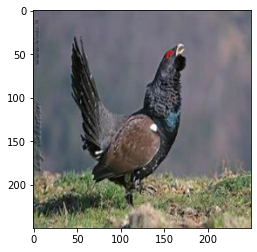

In [29]:
show(*dataset[random.randint(1,len(dataset))])

In [30]:
random_seed = 42
torch.manual_seed(random_seed)
val_size = int(0.1 * len(dataset))
test_size = int(0.1 * len(dataset))
train_size = len(dataset) - val_size - test_size
train_size + val_size + test_size

26179

In [31]:
train_subset, val_subset, test_set = random_split(dataset, [train_size, val_size, test_size])

In [32]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

train_set = MyDataSet(train_subset, transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomCrop(250, padding=50, padding_mode='reflect'),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(*stats, inplace=True),

    ]))

val_set = MyDataSet(train_subset, transform = transforms.Normalize(*stats, inplace=True))


test_set = MyDataSet(train_subset, transform = transforms.Normalize(*stats, inplace=True))


In [33]:
len(test_set), len(train_set)
train_set[0][0].shape

torch.Size([3, 250, 250])

In [34]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(24,6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
        break

In [35]:
batch_size = 64
train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_set, batch_size, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_set, batch_size, num_workers=4, pin_memory=True)

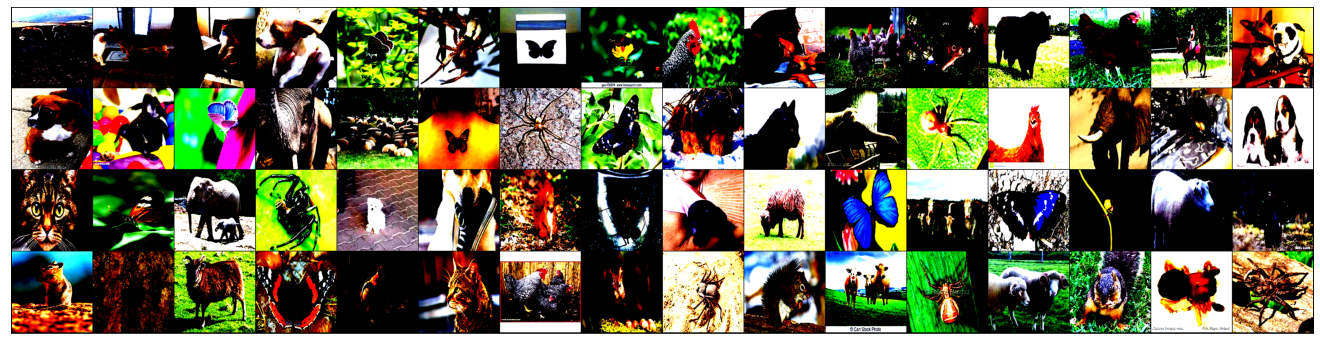

In [36]:
show_batch(val_loader)

In [37]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    valid_preds = torch.sum(preds == labels).item()
    all_preds = len(preds)
    return torch.tensor(valid_preds/all_preds)

In [38]:
class ModelBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
    

In [39]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

    
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()
            lrs.append(get_lr(optimizer))
            sched.step()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [40]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [41]:
device = get_default_device()
device

device(type='cuda')

In [42]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [43]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [44]:
input_size = 3 
output_size = 10

In [45]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(5))
    return nn.Sequential(*layers)

class Model1(ModelBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512,512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(2), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [46]:
class Model2(ModelBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [47]:
model = Model1(3,10)

In [48]:
model

Model1(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

In [49]:
for images, labels in train_loader:
    print('images.shape: ', images.shape)
    out = model(images)
    print('out.shape: ', out.shape)
    print("out[0]: ", out[0])
    break

images.shape:  torch.Size([64, 3, 250, 250])
out.shape:  torch.Size([64, 10])
out[0]:  tensor([ 2.5321, -2.6366,  2.4351,  0.0271, -1.4863,  4.2557,  1.8952,  1.2835,
         3.9888, -1.4807], grad_fn=<SelectBackward>)


In [50]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [51]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)
device = get_default_device()
device
to_device(model, device)

Model1(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

In [52]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [53]:
evaluate(model, val_loader)

{'val_loss': 2.3076908588409424, 'val_acc': 0.0645960345864296}

In [54]:
evaluate(model, test_loader)

{'val_loss': 2.3076908588409424, 'val_acc': 0.0645960345864296}

In [55]:
%%time
history = []
history += fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00279, train_loss: 1.4272, val_loss: 1.5198, val_acc: 0.5296
Epoch [1], last_lr: 0.00760, train_loss: 1.3190, val_loss: 1.3101, val_acc: 0.6069
Epoch [2], last_lr: 0.01000, train_loss: 1.0868, val_loss: 0.9001, val_acc: 0.7037
Epoch [3], last_lr: 0.00950, train_loss: 0.7906, val_loss: 1.3034, val_acc: 0.6153
Epoch [4], last_lr: 0.00812, train_loss: 0.6629, val_loss: 0.6502, val_acc: 0.7954
Epoch [5], last_lr: 0.00611, train_loss: 0.5635, val_loss: 0.6782, val_acc: 0.7773
Epoch [6], last_lr: 0.00389, train_loss: 0.4828, val_loss: 0.3327, val_acc: 0.8956
Epoch [7], last_lr: 0.00188, train_loss: 0.3686, val_loss: 0.2923, val_acc: 0.9038
Epoch [8], last_lr: 0.00050, train_loss: 0.2658, val_loss: 0.1752, val_acc: 0.9466
Epoch [9], last_lr: 0.00000, train_loss: 0.2020, val_loss: 0.1592, val_acc: 0.9537
CPU times: user 6min 37s, sys: 4min 33s, total: 11min 10s
Wall time: 56min 42s


In [56]:
jovian.log_hyperparams({
    'num_epochs': epochs,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
#     'lr': lr,
    'arch': ' ResNet34'
#     'arch': '''            self.conv1 = conv_block(in_channels, 64)
#         self.conv2 = conv_block(64, 128, pool=True)
#         self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
#         self.conv3 = conv_block(128, 256, pool=True)
#         self.conv4 = conv_block(256, 512, pool=True)
#         self.res2 = nn.Sequential(conv_block(512,512), conv_block(512, 512))
        
#         self.classifier = nn.Sequential(nn.MaxPool2d(2), 
#                                         nn.Flatten(), 
#                                         nn.Linear(512, num_classes))
            
#             Scheduler, normalization'''
            
})

[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Hyperparams logged.


In [57]:
jovian.log_metrics(train_loss=history[-1]['train_loss'], 
                   val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'])

[jovian] Metrics logged.


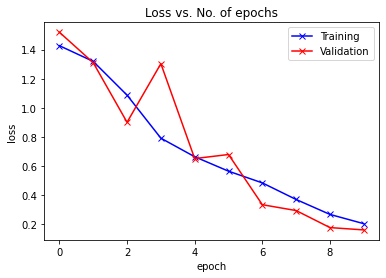

In [58]:
plot_losses(history)

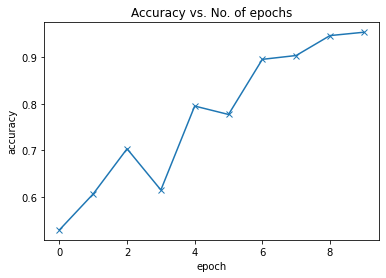

In [59]:
plot_accuracies(history)

In [ ]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/obciu13/course-project-animal-classification


<IPython.core.display.Javascript object>

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

In [ ]:
img, label = test_set[random.randint(1, len(test_set))]
plt.imshow(img.permute(1,2,0))
print('Label: ', translate[dataset.classes[label]], ', Predicted: ', translate[predict_image(img, model)])

In [ ]:
evaluate(model, val_loader)

In [ ]:
evaluate(model, test_loader)